In [4]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'

In [5]:
#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("HierarchicalClustering").enableHiveSupport().getOrCreate()

sc = spark.sparkContext

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col

# Initialize a Spark session
spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()

df = spark.read.csv("file:///home/talentum/shared/C-DAC_Project/Bank_Transaction_clean.csv", header=True, inferSchema=True)

df.show(5)
df.printSchema()

+-------------+----------+----------+------------------+-------------------+--------------------+-----------+------------+
|TransactionID|CustomerID|CustGender|CustAccountBalance|    TransactionDate|TransactionAmountINR|CustomerAge|CustLocation|
+-------------+----------+----------+------------------+-------------------+--------------------+-----------+------------+
|           T1|  C5841053|         F|          17819.05|2016-08-02 00:00:00|                25.0|         22|  JAMSHEDPUR|
|           T3|  C4417068|         F|          17874.44|2016-08-02 00:00:00|               459.0|         19|      MUMBAI|
|           T4|  C5342380|         F|          866503.2|2016-08-02 00:00:00|              2060.0|         43|      MUMBAI|
|           T5|  C9031234|         F|           6714.43|2016-08-02 00:00:00|              1762.5|         28|      MUMBAI|
|           T6|  C1536588|         F|           53609.2|2016-08-02 00:00:00|               676.0|         44|    ITANAGAR|
+-------------+-

In [7]:
# Selecting some essential features
selected_features = ['CustAccountBalance', 'TransactionAmountINR', 'CustomerAge']  

# Assemble the features into a feature vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
assembled_data = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

In [8]:
train_data, test_data = scaled_data.randomSplit([0.8, 0.2], seed=42)

In [9]:
# List to store WSSSE for each value of k
wssse_list = []

# Test different values of k (e.g., from 2 to 10)
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(featuresCol="scaled_features", k=k)
    model = kmeans.fit(scaled_data)
    wssse = model.summary.trainingCost  
    wssse_list.append(wssse)
    print(f"Within-Set Sum of Squared Errors (WSSSE) for k={k}: {wssse}")


Within-Set Sum of Squared Errors (WSSSE) for k=2: 2294179.2785260286
Within-Set Sum of Squared Errors (WSSSE) for k=3: 1661731.4242971162
Within-Set Sum of Squared Errors (WSSSE) for k=4: 1270519.3163925745
Within-Set Sum of Squared Errors (WSSSE) for k=5: 1250472.3686415022
Within-Set Sum of Squared Errors (WSSSE) for k=6: 882431.8319383902
Within-Set Sum of Squared Errors (WSSSE) for k=7: 734949.7738824183
Within-Set Sum of Squared Errors (WSSSE) for k=8: 616644.0883046531
Within-Set Sum of Squared Errors (WSSSE) for k=9: 540138.26195008
Within-Set Sum of Squared Errors (WSSSE) for k=10: 517674.5109346539


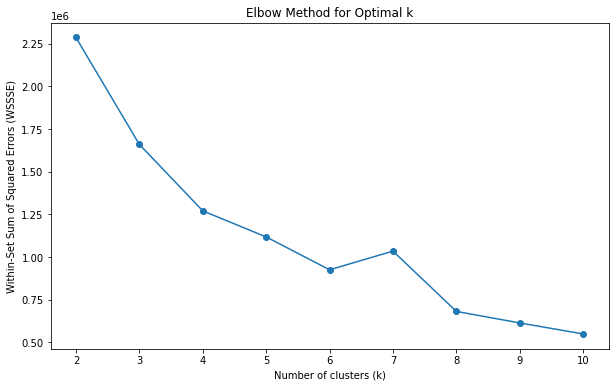

In [7]:
# Plot the WSSSE values against k values to visualize the elbow
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))
plt.plot(k_values, wssse_list, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-Set Sum of Squared Errors (WSSSE)")
plt.show()

In [10]:
#K=6
# Initialize the K-Means model
kmeans = KMeans(featuresCol="scaled_features", k=6) 

# Fit the model on the training data
model = kmeans.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

In [11]:
# Evaluate clustering by computing the Silhouette score
evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette = evaluator.evaluate(predictions)
print(f"Silhouette score = {silhouette}")

Silhouette score = 0.6670919548029296


In [18]:
# best is k=6
#Silhouette score = 0.6670919548029296

# cluster details

In [12]:
# Show the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.09932485 0.15554586 4.38411262]
[0.21848917 0.27597137 6.11300749]
[ 0.63114365 11.2022457   5.55162246]
[41.66242664  0.92972179  6.59250494]
[1.42411936e-01 2.26957286e+02 6.85421118e+00]
[7.67886008 0.54439974 6.18531937]


In [13]:
#These are the centroids or the average points of each cluster. In this case, we have six cluster centers, 
#each represented by three coordinates (likely features or dimensions in your data).

In [14]:
# Count the number of data points in each cluster
cluster_counts = predictions.groupBy("prediction").count().orderBy(col("count").desc())
cluster_counts.show()

+----------+------+
|prediction| count|
+----------+------+
|         0|117754|
|         1| 63894|
|         5|   885|
|         2|   634|
|         3|    48|
|         4|     2|
+----------+------+



In [15]:
from pyspark.sql import functions as F
# Define sql_min as a wrapper around F.min
def sql_min(column):
    return F.min(column)

# Define sql_max as a wrapper around F.max
def sql_max(column):
    return F.max(column)

In [16]:
# Analyze clusters

for i in range(kmeans.getK()):
    print(f"Cluster {i}:")
    
    # Filter data for each cluster
    cluster_data = predictions.filter(col("prediction") == i)
    
    # Total data points in the cluster
    total_points = cluster_data.count()
    print(f"  Total data points: {total_points}")
    
    # Min and Max values for each feature in the cluster
    for feature in ['CustAccountBalance', 'TransactionAmountINR', 'CustomerAge']:
        min_val = cluster_data.agg(sql_min(col(feature))).first()[0]
        max_val = cluster_data.agg(sql_max(col(feature))).first()[0]
        print(f"  {feature} - Min: {min_val}, Max: {max_val}")

Cluster 0:
  Total data points: 117754
  CustAccountBalance - Min: 0.0, Max: 1764546.1
  TransactionAmountINR - Min: 0.0, Max: 32300.0
  CustomerAge - Min: 18, Max: 30
Cluster 1:
  Total data points: 63894
  CustAccountBalance - Min: 0.0, Max: 1755163.9
  TransactionAmountINR - Min: 0.0, Max: 32300.0
  CustomerAge - Min: 28, Max: 45
Cluster 2:
  Total data points: 634
  CustAccountBalance - Min: 0.0, Max: 5037076.5
  TransactionAmountINR - Min: 32123.27, Max: 600003.44
  CustomerAge - Min: 18, Max: 45
Cluster 3:
  Total data points: 48
  CustAccountBalance - Min: 11091701.0, Max: 43165556.0
  TransactionAmountINR - Min: 10.32, Max: 30000.0
  CustomerAge - Min: 28, Max: 45
Cluster 4:
  Total data points: 2
  CustAccountBalance - Min: 14177.65, Max: 98660.33
  TransactionAmountINR - Min: 720001.2, Max: 1380002.9
  CustomerAge - Min: 31, Max: 38
Cluster 5:
  Total data points: 885
  CustAccountBalance - Min: 1710172.6, Max: 10546546.0
  TransactionAmountINR - Min: 0.0, Max: 90599.0
  Cust